In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import calendar

In [25]:
df = pd.read_csv('combined.csv')

In [26]:
crop_map = {
    ("MP", "Kharif"): ["SB", "PA"],
    ("MP", "Rabi"): ["WH", "GM"],
    ("MH", "Kharif"): ["CO", "SB"],
    ("MH", "Rabi"): ["WH", "GM"]
}

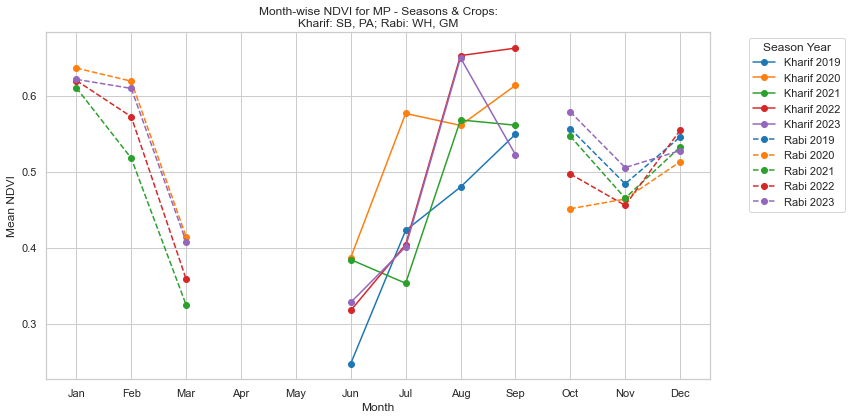

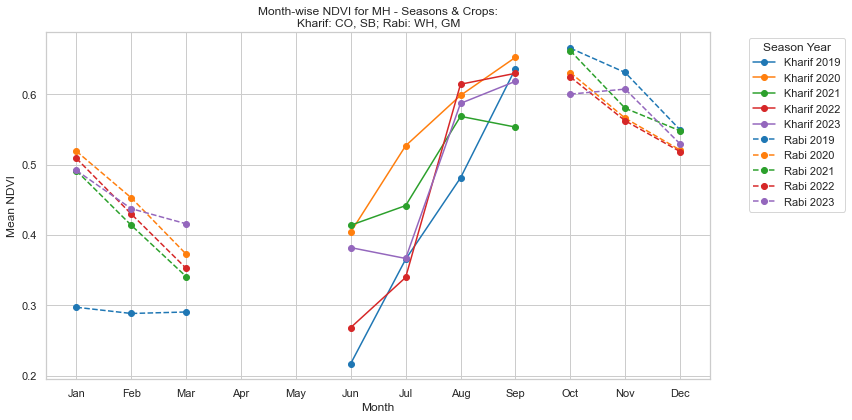

In [27]:
def plot_state_ndvi_year_colors(df, state):
    plt.figure(figsize=(12,6))
    months = list(range(1, 13))
    month_names = [calendar.month_abbr[m] for m in months]

    df_sub = df[(df['State'] == state) & (df['Season'] != 'Off-season')]
    seasons = df_sub['Season'].unique()
    years = sorted(df_sub['Year'].unique())
    
    year_colors = sns.color_palette("tab10", n_colors=len(years))
    year_color_map = dict(zip(years, year_colors))

    season_linestyles = {'Kharif': 'solid', 'Rabi': 'dashed'}

    for season in seasons:
        full_idx = pd.MultiIndex.from_product([years, months], names=['Year', 'Month'])
        monthly = df_sub[df_sub['Season'] == season].groupby(['Year', 'Month'])['NDVI'].mean().reindex(full_idx).reset_index()

        for year in years:
            data = monthly[monthly['Year'] == year]
            plt.plot(data['Month'], data['NDVI'],
                     color=year_color_map[year],
                     linestyle=season_linestyles.get(season, 'solid'),
                     marker='o',
                     label=f'{season} {year}')

    plt.xticks(ticks=months, labels=month_names)
    plt.xlabel('Month')
    plt.ylabel('Mean NDVI')
    crops = [", ".join(crop_map[(state, s)]) for s in seasons]
    plt.title(f'Month-wise NDVI for {state} - Seasons & Crops:\n' + "; ".join([f"{s}: {c}" for s,c in zip(seasons, crops)]))
    plt.legend(title='Season Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for state in ['MP', 'MH']:
    plot_state_ndvi_year_colors(df, state)


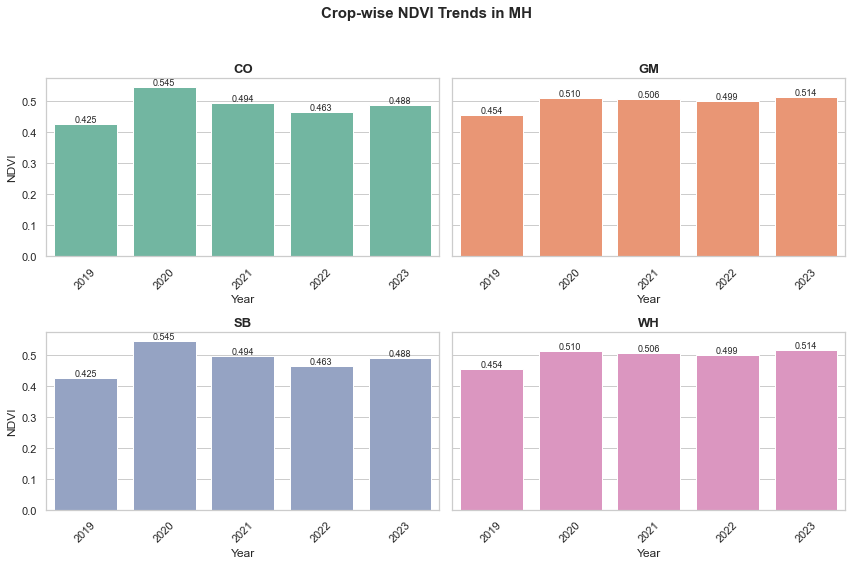

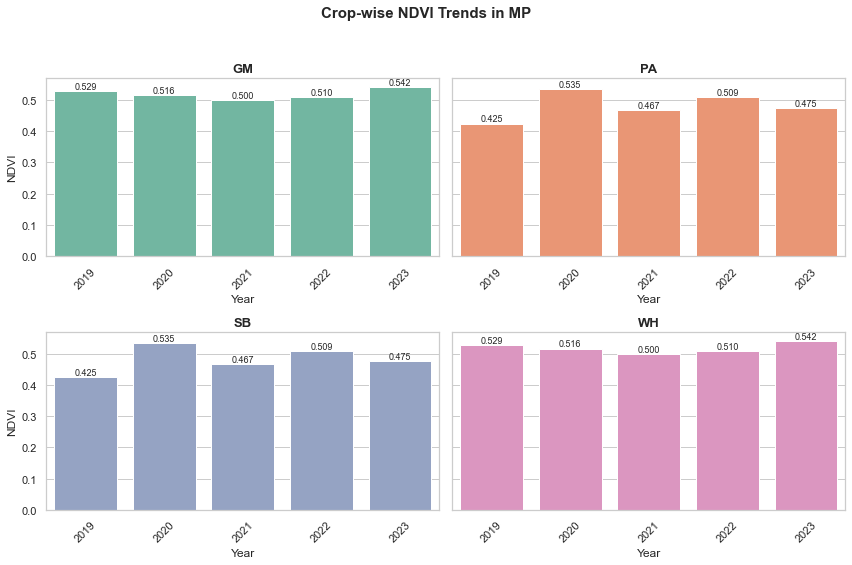

In [28]:

expanded_rows = []
for _, row in df.iterrows():
    crops = crop_map.get((row["State"], row["Season"]), [])
    for crop in crops:
        new_row = row.copy()
        new_row["Crop"] = crop
        expanded_rows.append(new_row)

df_expanded = pd.DataFrame(expanded_rows)
df_expanded["Year"] = df_expanded["Year"].astype(str)

states = df_expanded["State"].unique()
palette = sns.color_palette("Set2")

for state in states:
    state_df = df_expanded[df_expanded["State"] == state]
    crops = sorted(state_df["Crop"].unique())
    num_crops = len(crops)

    nrows, ncols = 2, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharey=True)
    axes = axes.flatten()

    for i, crop in enumerate(crops):
        ax = axes[i]
        crop_df = state_df[state_df["Crop"] == crop]
        sns.barplot(data=crop_df, x="Year", y="NDVI", ax=ax, color=palette[i % len(palette)], errorbar=None)
        for container in ax.containers:
            ax.bar_label(container, fmt="%.3f", fontsize=9)
        ax.set_title(f"{crop}", fontsize=13, fontweight="bold")
        ax.set_xlabel("Year")
        ax.set_ylabel("NDVI" if i % ncols == 0 else "")
        ax.tick_params(axis='x', rotation=45)

    for j in range(num_crops, nrows * ncols):
        fig.delaxes(axes[j])

    fig.suptitle(f"Crop-wise NDVI Trends in {state}", fontsize=15, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


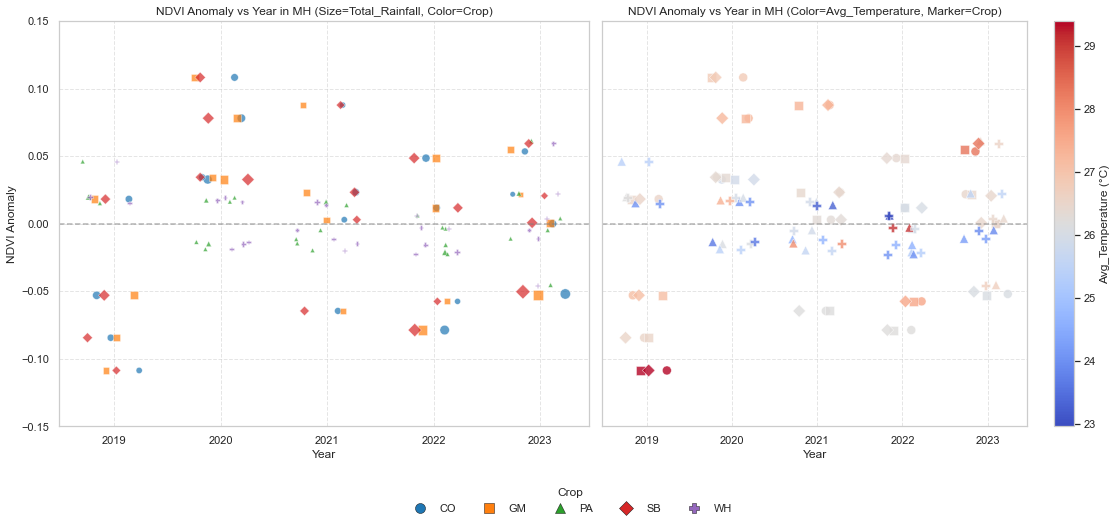

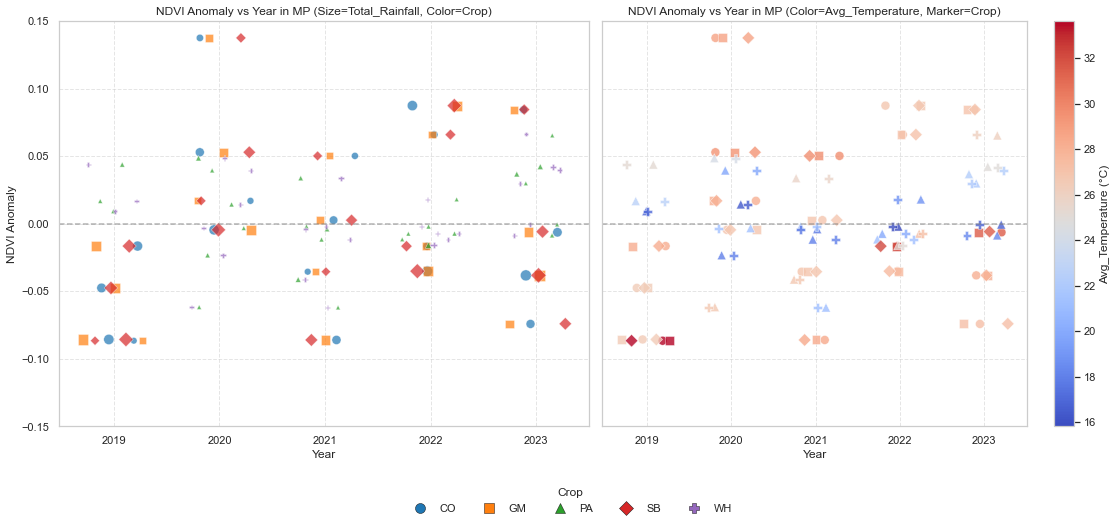

In [35]:

def plot_ndvi_anomaly_vs_year(
    df,
    state_col='State',
    crop_col='Crop',
    year_col='Year',
    ndvi_anomaly_col='NDVI_Anomaly',
    rainfall_col='Total_Rainfall',
    temp_col='Avg_Temperature',
    jitter_amount=0.3,
    figsize=(16,7),
    legend_location='lower center',
    legend_ncol=5,
    cmap='coolwarm'
):
    plot_df = df.copy()

    # Add jitter to year for better visibility
    plot_df['Year_jitter'] = plot_df[year_col] + np.random.uniform(-jitter_amount, jitter_amount, size=plot_df.shape[0])

    # Scale rainfall for marker size
    rain_min, rain_max = plot_df[rainfall_col].min(), plot_df[rainfall_col].max()
    plot_df['Rainfall_size'] = 100 * (plot_df[rainfall_col] - rain_min) / (rain_max - rain_min) + 20

    states = plot_df[state_col].unique()

    base_colors = sns.color_palette('tab10')
    base_markers = ['o', 's', '^', 'D', 'P', '*', 'X', 'v', '<', '>']

    for state in states:
        state_df = plot_df[plot_df[state_col] == state]

        fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

        categories = state_df[crop_col].unique()
        num_cats = len(categories)

        # Cycle colors and markers if needed
        colors = base_colors * (num_cats // len(base_colors) + 1)
        markers = base_markers * (num_cats // len(base_markers) + 1)

        color_map = dict(zip(categories, colors[:num_cats]))
        marker_map = dict(zip(categories, markers[:num_cats]))

        # Left plot: NDVI Anomaly vs Year, size by rainfall, color by category
        for cat in categories:
            cat_df = state_df[state_df[crop_col] == cat]
            axes[0].scatter(
                cat_df['Year_jitter'],
                cat_df[ndvi_anomaly_col],
                s=cat_df['Rainfall_size'],
                color=color_map[cat],
                alpha=0.7,
                edgecolors='w',
                linewidth=0.5,
                marker=marker_map[cat]  # <--- add marker here
            )
        axes[0].set_title(f'NDVI Anomaly vs Year in {state} (Size={rainfall_col}, Color={crop_col})')
        axes[0].set_xlabel('Year')
        axes[0].set_ylabel('NDVI Anomaly')
        axes[0].axhline(0, color='grey', linestyle='--', alpha=0.6)
        axes[0].grid(True, linestyle='--', alpha=0.5)

        # Right plot: NDVI Anomaly vs Year, color by temperature, marker shape by category
        temp_min = state_df[temp_col].min()
        temp_max = state_df[temp_col].max()
        if np.isclose(temp_min, temp_max):
            temp_min -= 0.5
            temp_max += 0.5

        for cat in categories:
            cat_df = state_df[state_df[crop_col] == cat]
            axes[1].scatter(
                cat_df['Year_jitter'],
                cat_df[ndvi_anomaly_col],
                c=cat_df[temp_col],
                cmap=cmap,
                s=80,
                alpha=0.8,
                vmin=temp_min,
                vmax=temp_max,
                marker=marker_map[cat],
                edgecolors='w',
                linewidth=0.5
            )

        cbar = fig.colorbar(
            plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=temp_min, vmax=temp_max)),
            ax=axes[1]
        )
        cbar.set_label(f'{temp_col} (°C)')

        axes[1].set_title(f'NDVI Anomaly vs Year in {state} (Color={temp_col}, Marker={crop_col})')
        axes[1].set_xlabel('Year')
        axes[1].set_ylabel('')
        axes[1].axhline(0, color='grey', linestyle='--', alpha=0.6)
        axes[1].grid(True, linestyle='--', alpha=0.5)

        # Create combined legend with marker shape & color
        legend_handles = [
            Line2D([0], [0], marker=marker_map[cat], color='w',
                   label=cat,
                   markerfacecolor=color_map[cat],
                   markersize=10,
                   markeredgecolor='k',
                   markeredgewidth=0.5)
            for cat in categories
        ]

        fig.legend(
            handles=legend_handles,
            loc=legend_location,
            ncol=min(num_cats, legend_ncol),
            bbox_to_anchor=(0.5, -0.05),
            frameon=False,
            title=crop_col
        )
        axes[0].set_ylim(-0.15, 0.15)
        axes[1].set_ylim(-0.15, 0.15)
        plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
        plt.show()

plot_ndvi_anomaly_vs_year(
    merged_df,
    state_col='State',
    crop_col='Crop',
    year_col='Year',
    ndvi_anomaly_col='NDVI_Anomaly',
    rainfall_col='Total_Rainfall',
    temp_col='Avg_Temperature'
)

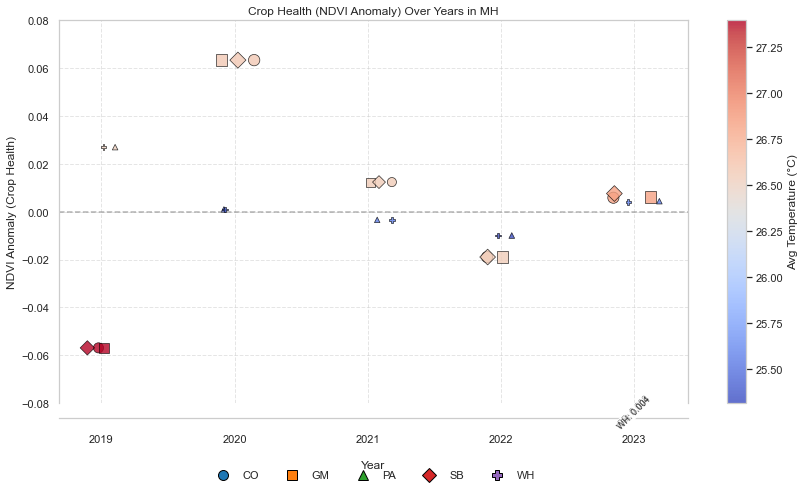

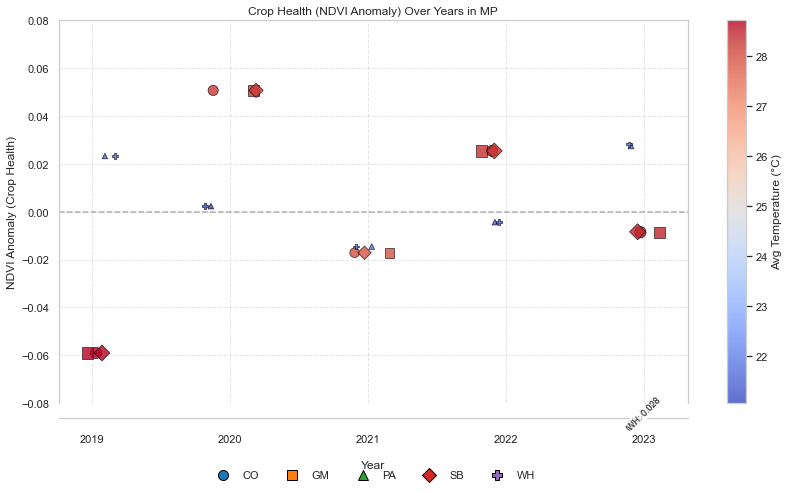

In [41]:
yearly_df = df.groupby(['State', 'Crop', 'Year']).agg({
    'NDVI_Anomaly': 'mean',
    'Avg_Temperature': 'mean',
    'Total_Rainfall': 'mean'
}).reset_index()

marker_styles = ['o', 's', '^', 'D', 'P', '*', 'X', 'v', '<', '>']

states = yearly_df['State'].unique()
palette = sns.color_palette('tab10')

for state in states:
    state_df = yearly_df[yearly_df['State'] == state].copy()

    crops = state_df['Crop'].unique()
    crop_markers = {crop: marker_styles[i % len(marker_styles)] for i, crop in enumerate(crops)}
    crop_colors = {crop: palette[i % len(palette)] for i, crop in enumerate(crops)}

    rain_min, rain_max = state_df['Total_Rainfall'].min(), state_df['Total_Rainfall'].max()
    state_df['Rainfall_size'] = 100 * (state_df['Total_Rainfall'] - rain_min) / (rain_max - rain_min) + 30

    plt.figure(figsize=(12, 7))

    jitter_strength = 0.2
    for crop in crops:
        crop_df = state_df[state_df['Crop'] == crop]
        x_jittered = crop_df['Year'] + np.random.uniform(-jitter_strength, jitter_strength, size=crop_df.shape[0])

        plt.scatter(
            x_jittered,
            crop_df['NDVI_Anomaly'],
            s=crop_df['Rainfall_size'],
            c=crop_df['Avg_Temperature'],
            cmap='coolwarm',
            marker=crop_markers[crop],
            edgecolor='black',
            linewidth=0.7,
            alpha=0.8,
            label=crop,
            vmin=state_df['Avg_Temperature'].min(),
            vmax=state_df['Avg_Temperature'].max()
        )

    plt.colorbar(label='Avg Temperature (°C)')
    plt.axhline(0, color='grey', linestyle='--', alpha=0.6)

    plt.title(f'Crop Health (NDVI Anomaly) Over Years in {state}')
    plt.xlabel('Year')
    plt.ylabel('NDVI Anomaly (Crop Health)')

    years = sorted(state_df['Year'].unique())
    plt.xticks(years)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_axisbelow(True) 

    ax = plt.gca()
    ax.xaxis.set_label_coords(0.5, -0.15)  # Move x-axis label down (adjust -0.15 as needed)
    ax.tick_params(axis='x', which='both', pad=10)  # Increase padding of x-tick labels
    ax.spines['bottom'].set_position(('outward', 15))  # Move x-axis spine downward

    handles = [Line2D([0], [0], marker=crop_markers[crop], color='w', label=crop,
                      markerfacecolor=crop_colors[crop], markersize=10,
                      markeredgecolor='black') for crop in crops]
    plt.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(crops),
        frameon=False
    )

    latest_year = max(years)
    latest_data = state_df[state_df['Year'] == latest_year]

    y_min, y_max = plt.ylim()
    label_y = y_min - 0.1 * (y_max - y_min)

    for crop in crops:
        crop_latest = latest_data[latest_data['Crop'] == crop]
        if not crop_latest.empty:
            x_pos = crop_latest['Year'].values[0]
            ndvi_val = crop_latest['NDVI_Anomaly'].values[0]
            plt.text(
                x_pos, label_y,
                f"{crop}: {ndvi_val:.3f}",
                ha='center', va='top',
                fontsize=9,
                rotation=45,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
            )

    plt.ylim(-0.08, 0.08) 
    plt.tight_layout()
    plt.show()


C:\Users\shaha\AppData\Local\Temp\ipykernel_3136\4238566743.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


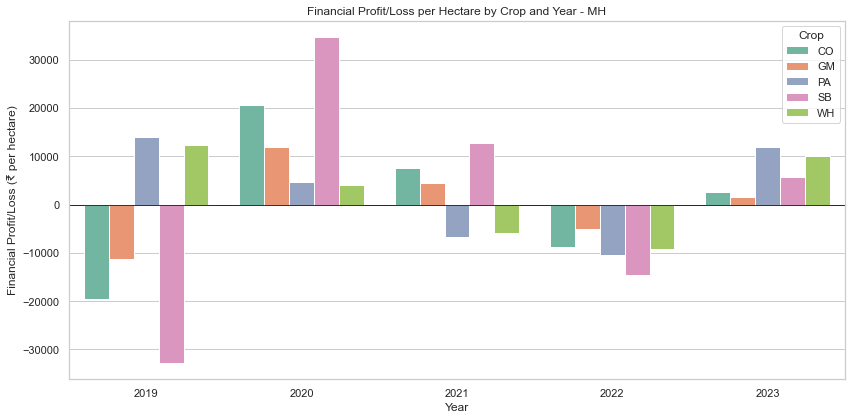

C:\Users\shaha\AppData\Local\Temp\ipykernel_3136\4238566743.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


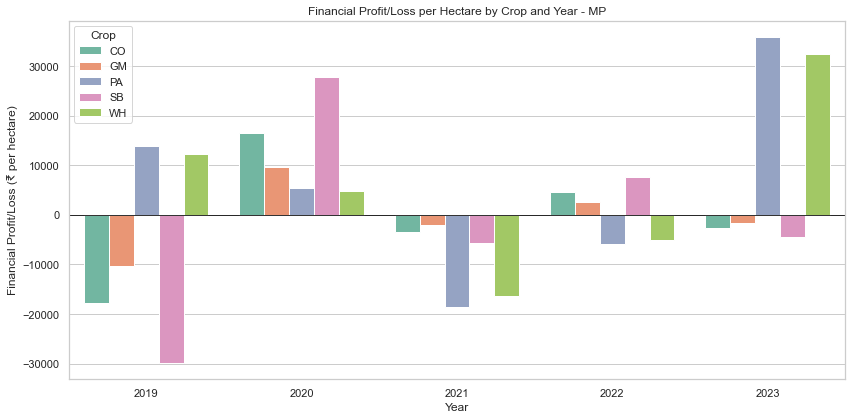

In [42]:

economic_data = {
    'Crop': ['CO', 'GM', 'SB', 'PA', 'WH'],
    'Baseline_Yield_tons': [0.447, 0.973, 1.250, 4.380, 3.560],  
    'Market_Price_per_ton': [75210, 20000, 45300, 22996, 24975]  
}
economic_df = pd.DataFrame(economic_data)
merged_df = df.merge(economic_df, on='Crop')

merged_df['Yield_Change_Percent'] = merged_df['NDVI_Anomaly'] / merged_df['Baseline_NDVI']

merged_df['Actual_Yield_tons'] = merged_df['Baseline_Yield_tons'] * (1 + merged_df['Yield_Change_Percent'])

merged_df['Yield_Reduction_tons'] = merged_df['Baseline_Yield_tons'] - merged_df['Actual_Yield_tons']

merged_df['Financial_Loss_per_hectare'] = merged_df['Yield_Reduction_tons'] * merged_df['Market_Price_per_ton']

summary_table = merged_df.groupby(['State', 'Crop', 'Year']).agg({
    'NDVI_Anomaly': 'mean',
    'Actual_Yield_tons': 'mean',
    'Financial_Loss_per_hectare': 'sum'
}).reset_index()

summary_table['Financial_Loss_per_hectare'] = -summary_table['Financial_Loss_per_hectare']

sns.set(style="whitegrid")
states = summary_table['State'].unique()

for state in states:
    plt.figure(figsize=(12, 6))
    state_data = summary_table[summary_table['State'] == state]
    sns.barplot(
        data=state_data,
        x='Year',
        y='Financial_Loss_per_hectare',
        hue='Crop',
        ci=None,
        palette='Set2'
    )
    plt.title(f'Financial Profit/Loss per Hectare by Crop and Year - {state}')
    plt.ylabel('Financial Profit/Loss (₹ per hectare)')
    plt.xlabel('Year')
    plt.axhline(0, color='black', linewidth=0.8)  
    plt.legend(title='Crop')
    plt.tight_layout()
    plt.show()
